In [64]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')   
import matplotlib.pyplot as plt

In [65]:
matchdata= pd.read_csv("C:/Users/hp/Downloads/664389efa0868_match_level_scorecard.csv")
test= pd.read_csv("C:/Users/hp/Downloads/6644a1e287df6_test_data_with_samplefeatures.csv")

In [66]:
matchdata.shape

(1689, 30)

In [67]:
matchdata.columns

Index(['match id', 'team1', 'team2', 'winner', 'by', 'win amount',
       'toss winner', 'toss decision', 'venue', 'city', 'match_dt', 'lighting',
       'series_name', 'season', 'ground_id', 'umpire1', 'umpire2',
       'inning1_runs', 'inning1_wickets', 'inning1_balls', 'inning2_runs',
       'inning2_wickets', 'inning2_balls', 'team1_id', 'team1_roster_ids',
       'team2_id', 'team2_roster_ids', 'series_type', 'winner_id',
       'player_of_the_match_id'],
      dtype='object')

In [68]:
matchdata.head(4)

,match id,team1,team2,winner,by,win amount,toss winner,toss decision,venue,city,...,inning2_runs,inning2_wickets,inning2_balls,team1_id,team1_roster_ids,team2_id,team2_roster_ids,series_type,winner_id,player_of_the_match_id
0,8638034,Nn Ds,Wn,Wn,wickets,9.0,Wn,field,By Ol,Mount Maunganui,...,152.0,1.0,97.0,17982,7907451.0:4381761.0:31464.0:258649.0:4949790.0...,18570,2653993.0:6718326.0:6718382.0:2486896.0:228878...,other_domestic,18570,NaN
1,8588005,Me Rs,Sy Tr,Sy Tr,runs,7.0,Sy Tr,field,Ca Ol,Carrara,...,117.0,2.0,74.0,33942,37351.0:46794.0:5406540.0:2231928.0:181404.0:1...,33963,1506098.0:1749075.0:36665.0:2083409.0:7534652....,other_domestic,33963,1749075.0
2,8587837,Sy Ss,Be Ht,Be Ht,wickets,4.0,Sy Ss,bat,Be Ct Gd,Brisbane,...,171.0,6.0,119.0,33956,7869987.0:7620283.0:2076192.0:4002340.0:306369...,33921,7620269.0:2286437.0:87191.0:5786766.0:3114803....,other_domestic,33921,3890984.0
3,8638041,Nn Ds,Oo,Oo,wickets,2.0,Oo,field,By Ol,Mount Maunganui,...,156.0,8.0,126.0,17982,7907451.0:4381761.0:31464.0:4949790.0:258649.0...,18360,2319638.0:256080.0:7918280.0:3913447.0:2690498...,other_domestic,18360,NaN


In [69]:
x= matchdata.drop(['venue', 'city','lighting', 'ground_id', 'umpire1', 'umpire2','series_type','team1_roster_ids','team2_roster_ids' ], axis=1)

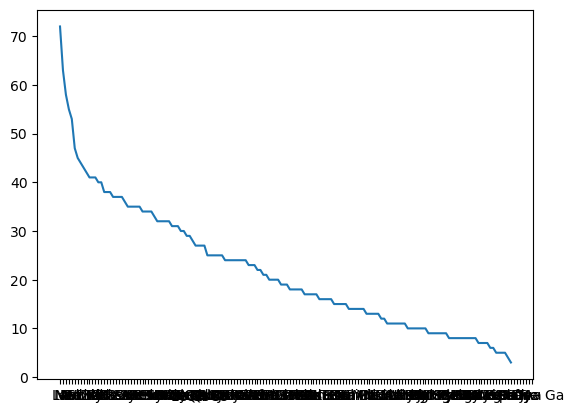

In [70]:
# Count the number of matches each team has played
team_counts = x['team1'].value_counts() + x['team2'].value_counts()
team_df= team_counts.reset_index()
team_df.columns= ['team', 'games']
team_df= team_df.sort_values(by='games', ascending = False).reset_index(drop= True)
plt.plot(team_df['team'], team_df['games'])

In [71]:
# Ensure 'match_dt' is datetime
x['match_dt'] = pd.to_datetime(x['match_dt'])

# Function to calculate bat_first, run rate and NRR
def calculate_run_rate_nrr(row):
    matches = x[x['match_dt'] < row['match_dt']]
    
    if ((row['toss winner'] == row['team1'] and row['toss decision'] == 'bat') or 
        (row['toss winner'] == row['team2'] and row['toss decision'] == 'field')):
        row['bat_first'] = row['team1']
    else:
        row['bat_first'] = row['team2']
        
    team1 = row['team1']
    team2 = row['team2']
    
    team1_matches = matches[(matches['team1'] == team1) | (matches['team2'] == team1)]
    team2_matches = matches[(matches['team1'] == team2) | (matches['team2'] == team2)]
    
    def get_run_rate(matches, team):
        runs_scored = matches.apply(lambda r: r['inning1_runs'] if (r['team1'] == team and r['toss winner'] == team and r['toss decision'] == 'bat') or 
                                                    (r['team2'] == team and r['toss winner'] == r['team1'] and r['toss decision'] == 'field')
                                        else r['inning2_runs'], axis=1).sum()
        balls_faced = matches.apply(lambda r: r['inning1_balls'] if (r['team1'] == team and r['toss winner'] == team and r['toss decision'] == 'bat') or 
                                                    (r['team2'] == team and r['toss winner'] == r['team1'] and r['toss decision'] == 'field')
                                        else r['inning2_balls'], axis=1).sum()
        return (6 * runs_scored) / balls_faced if balls_faced > 0 else 0
    
    def get_against_run_rate(matches, team):
        runs_scored = matches.apply(lambda r: r['inning2_runs'] if (r['team1'] == team and r['toss winner'] == team and r['toss decision'] == 'bat') or 
                                                    (r['team2'] == team and r['toss winner'] == r['team1'] and r['toss decision'] == 'field')
                                        else r['inning1_runs'], axis=1).sum()
        balls_faced = matches.apply(lambda r: r['inning2_balls'] if (r['team1'] == team and r['toss winner'] == team and r['toss decision'] == 'bat') or 
                                                    (r['team2'] == team and r['toss winner'] == r['team1'] and r['toss decision'] == 'field')
                                        else r['inning1_balls'], axis=1).sum()
        return (6 * runs_scored) / balls_faced if balls_faced > 0 else 0
    
    team1_run_rate = get_run_rate(team1_matches, team1)
    team1_against_run_rate = get_against_run_rate(team1_matches, team1)
    team2_run_rate = get_run_rate(team2_matches, team2)
    team2_against_run_rate = get_against_run_rate(team2_matches, team2)
    
    team1_nrr = team1_run_rate - team1_against_run_rate
    team2_nrr = team2_run_rate - team2_against_run_rate
    
    return pd.Series([row['bat_first'], team1_run_rate, team2_run_rate, team1_nrr, team2_nrr])

# Apply the function to each row
x[['bat_first', 'team1_run_rate_overall', 'team2_run_rate_overall', 'team1_nrr_overall', 'team2_nrr_overall']] = x.apply(calculate_run_rate_nrr, axis=1)




In [72]:
test[['bat_first', 'team1_run_rate_overall', 'team2_run_rate_overall', 'team1_nrr_overall', 'team2_nrr_overall']] = test.apply(calculate_run_rate_nrr, axis=1)

In [73]:
x.sort_values(by='match_dt', inplace=True)

In [74]:
x['team1_run_rate'] = x.apply(lambda data: 6*data['inning1_runs'] / data['inning1_balls'] if data['bat_first']== data['team1'] else 6*data['inning2_runs'] / data['inning2_balls'], axis=1)
x['team2_run_rate'] = x.apply(lambda data: 6*data['inning1_runs'] / data['inning1_balls'] if data['bat_first']== data['team2'] else 6*data['inning2_runs'] / data['inning2_balls'], axis=1)


In [75]:
# Function to calculate bat_first, run rate and NRR
def series_rates(row):
    matches = x[(x['match_dt'] < row['match_dt']) & (x['season']==row['season'])]
    
    team1 = row['team1']
    team2 = row['team2']
    
    team1_matches = matches[(matches['team1'] == team1) | (matches['team2'] == team1)]
    team2_matches = matches[(matches['team1'] == team2) | (matches['team2'] == team2)]
    
    def get_run_rate(matches, team):
        runs_scored = matches.apply(lambda r: r['inning1_runs'] if (r['team1'] == team and r['toss winner'] == team and r['toss decision'] == 'bat') or 
                                                    (r['team2'] == team and r['toss winner'] == r['team1'] and r['toss decision'] == 'field')
                                        else r['inning2_runs'], axis=1).sum()
        balls_faced = matches.apply(lambda r: r['inning1_balls'] if (r['team1'] == team and r['toss winner'] == team and r['toss decision'] == 'bat') or 
                                                    (r['team2'] == team and r['toss winner'] == r['team1'] and r['toss decision'] == 'field')
                                        else r['inning2_balls'], axis=1).sum()
        return (6 * runs_scored) / balls_faced if balls_faced > 0 else 0
    
    def get_against_run_rate(matches, team):
        runs_scored = matches.apply(lambda r: r['inning2_runs'] if (r['team1'] == team and r['toss winner'] == team and r['toss decision'] == 'bat') or 
                                                    (r['team2'] == team and r['toss winner'] == r['team1'] and r['toss decision'] == 'field')
                                        else r['inning1_runs'], axis=1).sum()
        balls_faced = matches.apply(lambda r: r['inning2_balls'] if (r['team1'] == team and r['toss winner'] == team and r['toss decision'] == 'bat') or 
                                                    (r['team2'] == team and r['toss winner'] == r['team1'] and r['toss decision'] == 'field')
                                        else r['inning1_balls'], axis=1).sum()
        return (6 * runs_scored) / balls_faced if balls_faced > 0 else 0
    
    team1_run_rate = get_run_rate(team1_matches, team1)
    team1_against_run_rate = get_against_run_rate(team1_matches, team1)
    team2_run_rate = get_run_rate(team2_matches, team2)
    team2_against_run_rate = get_against_run_rate(team2_matches, team2)
    
    team1_nrr = team1_run_rate - team1_against_run_rate
    team2_nrr = team2_run_rate - team2_against_run_rate
    
    return pd.Series([team1_run_rate, team2_run_rate, team1_nrr, team2_nrr])

# Apply the function to each row
x[[ 'team1_run_rate_season', 'team2_run_rate_season', 'team1_nrr_season', 'team2_nrr_season']] = x.apply(series_rates, axis=1)


In [76]:
test[[ 'team1_run_rate_season', 'team2_run_rate_season', 'team1_nrr_season', 'team2_nrr_season']] = test.apply(series_rates, axis=1)


In [77]:
# Function to calculate bat_first, run rate and NRR
def season_rates(row):
    matches = x[(x['match_dt'] < row['match_dt']) & (x['series_name']==row['series_name'])]
    
    team1 = row['team1']
    team2 = row['team2']
    
    team1_matches = matches[(matches['team1'] == team1) | (matches['team2'] == team1)]
    team2_matches = matches[(matches['team1'] == team2) | (matches['team2'] == team2)]

    def get_run_rate(matches, team):
        runs_scored = matches.apply(lambda r: r['inning1_runs'] if (r['team1'] == team and r['toss winner'] == team and r['toss decision'] == 'bat') or 
                                                    (r['team2'] == team and r['toss winner'] == r['team1'] and r['toss decision'] == 'field')
                                        else r['inning2_runs'], axis=1).sum()
        balls_faced = matches.apply(lambda r: r['inning1_balls'] if (r['team1'] == team and r['toss winner'] == team and r['toss decision'] == 'bat') or 
                                                    (r['team2'] == team and r['toss winner'] == r['team1'] and r['toss decision'] == 'field')
                                        else r['inning2_balls'], axis=1).sum()
        return (6 * runs_scored) / balls_faced if balls_faced > 0 else 0
    
    def get_against_run_rate(matches, team):
        runs_scored = matches.apply(lambda r: r['inning2_runs'] if (r['team1'] == team and r['toss winner'] == team and r['toss decision'] == 'bat') or 
                                                    (r['team2'] == team and r['toss winner'] == r['team1'] and r['toss decision'] == 'field')
                                        else r['inning1_runs'], axis=1).sum()
        balls_faced = matches.apply(lambda r: r['inning2_balls'] if (r['team1'] == team and r['toss winner'] == team and r['toss decision'] == 'bat') or 
                                                    (r['team2'] == team and r['toss winner'] == r['team1'] and r['toss decision'] == 'field')
                                        else r['inning1_balls'], axis=1).sum()
        return (6 * runs_scored) / balls_faced if balls_faced > 0 else 0
    
    team1_run_rate = get_run_rate(team1_matches, team1)
    team1_against_run_rate = get_against_run_rate(team1_matches, team1)
    team2_run_rate = get_run_rate(team2_matches, team2)
    team2_against_run_rate = get_against_run_rate(team2_matches, team2)
    
    team1_nrr = team1_run_rate - team1_against_run_rate
    team2_nrr = team2_run_rate - team2_against_run_rate
    
    return pd.Series([team1_run_rate, team2_run_rate, team1_nrr, team2_nrr])

# Apply the function to each row
x[[ 'team1_run_rate_series', 'team2_run_rate_series', 'team1_nrr_series', 'team2_nrr_series']] = x.apply(season_rates, axis=1)


In [78]:
# Apply the function to each row
test[[ 'team1_run_rate_series', 'team2_run_rate_series', 'team1_nrr_series', 'team2_nrr_series']] = test.apply(season_rates, axis=1)

In [79]:
# Function to calculate bat_first, run rate and NRR
def rolling_rates(row):
    matches = x[x['match_dt'] < row['match_dt']]
    
    team1 = row['team1']
    team2 = row['team2']
    
    team1_matches = matches[(matches['team1'] == team1) | (matches['team2'] == team1)]
    team1_matches= team1_matches.sort_values(by='match_dt', ascending=False).head(10)
    team2_matches = matches[(matches['team1'] == team2) | (matches['team2'] == team2)]
    team2_matches= team2_matches.sort_values(by='match_dt', ascending=False).head(10)

    def get_run_rate(matches, team):
        runs_scored = matches.apply(lambda r: r['inning1_runs'] if (r['team1'] == team and r['toss winner'] == team and r['toss decision'] == 'bat') or 
                                                    (r['team2'] == team and r['toss winner'] == r['team1'] and r['toss decision'] == 'field')
                                        else r['inning2_runs'], axis=1).sum()
        balls_faced = matches.apply(lambda r: r['inning1_balls'] if (r['team1'] == team and r['toss winner'] == team and r['toss decision'] == 'bat') or 
                                                    (r['team2'] == team and r['toss winner'] == r['team1'] and r['toss decision'] == 'field')
                                        else r['inning2_balls'], axis=1).sum()
        return (6 * runs_scored) / balls_faced if balls_faced > 0 else 0
    
    def get_against_run_rate(matches, team):
        runs_scored = matches.apply(lambda r: r['inning2_runs'] if (r['team1'] == team and r['toss winner'] == team and r['toss decision'] == 'bat') or 
                                                    (r['team2'] == team and r['toss winner'] == r['team1'] and r['toss decision'] == 'field')
                                        else r['inning1_runs'], axis=1).sum()
        balls_faced = matches.apply(lambda r: r['inning2_balls'] if (r['team1'] == team and r['toss winner'] == team and r['toss decision'] == 'bat') or 
                                                    (r['team2'] == team and r['toss winner'] == r['team1'] and r['toss decision'] == 'field')
                                        else r['inning1_balls'], axis=1).sum()
        return (6 * runs_scored) / balls_faced if balls_faced > 0 else 0
    
    team1_run_rate = get_run_rate(team1_matches, team1)
    team1_against_run_rate = get_against_run_rate(team1_matches, team1)
    team2_run_rate = get_run_rate(team2_matches, team2)
    team2_against_run_rate = get_against_run_rate(team2_matches, team2)
    
    team1_nrr = team1_run_rate - team1_against_run_rate
    team2_nrr = team2_run_rate - team2_against_run_rate
    
    return pd.Series([team1_run_rate, team2_run_rate, team1_nrr, team2_nrr])

# Apply the function to each row
x[[ 'team1_run_rate_last10', 'team2_run_rate_last10', 'team1_nrr_last10', 'team2_nrr_last10']] = x.apply(rolling_rates, axis=1)


In [80]:
# Apply the function to each row
test[[ 'team1_run_rate_last10', 'team2_run_rate_last10', 'team1_nrr_last10', 'team2_nrr_last10']] = test.apply(rolling_rates, axis=1)


In [83]:
def rw_features(row):
    matches = x[x['match_dt'] < row['match_dt']]
    season_matches= x[(x['match_dt'] < row['match_dt']) & (x['season']==row['season'])]
    series_matches= x[(x['match_dt'] < row['match_dt']) & (x['series_name']==row['series_name'])]
    
    team1 = row['team1']
    team2 = row['team2']
    
    team1_matches = matches[(matches['team1'] == team1) | (matches['team2'] == team1)]
    team1_matches_rolling = team1_matches.sort_values(by='match_dt', ascending=False).head(10)
    team1_matches_season = season_matches[(season_matches['team1'] == team1) | (season_matches['team2'] == team1)]
    team1_matches_series = series_matches[(series_matches['team1'] == team1) | (series_matches['team2'] == team1)]
    
    team2_matches = matches[(matches['team1'] == team2) | (matches['team2'] == team2)]
    team2_matches_rolling = team2_matches.sort_values(by='match_dt', ascending=False).head(10)
    team2_matches_season = season_matches[(season_matches['team1'] == team2) | (season_matches['team2'] == team2)]
    team2_matches_series = series_matches[(series_matches['team1'] == team2) | (series_matches['team2'] == team2)]
    
    def average_runs(match, team):
        runs_scored = match.apply(lambda r: r['inning1_runs'] if team == r['bat_first'] else r['inning2_runs'], axis=1).mean()
        return runs_scored
    def average_wickets(match, team):
        wickets = match.apply(lambda r: r['inning2_wickets'] if team == r['bat_first'] else r['inning1_wickets'], axis=1).median()
        return wickets
    def ratio(match, team):
        runs_scored = match.apply(lambda r: r['inning1_runs'] if team == r['bat_first'] else r['inning2_runs'], axis=1).mean()
        wickets = match.apply(lambda r: r['inning1_wickets'] if team == r['bat_first'] else r['inning2_wickets'], axis=1).median()
        return runs_scored/wickets 
    
    
    
    def win_percent(match,team):
        wins = match[match['winner'] == team].shape[0]
        total_matches= len(match)
        win_percentage = (wins / total_matches) * 100 if total_matches > 0 else 0
        return win_percentage
    
    def victory_by(match, team):
        cum_runs= 0
        cum_wks=0
        team_wins = match[match['winner'] == team]
        team_loss=  match[match['winner'] != team]

        # Calculate cumulative runs and wickets
        cum_runs = team_wins.loc[team_wins['by'] == 'runs', 'win amount'].sum()
        cum_wks = team_wins.loc[team_wins['by'] == 'wickets', 'win amount'].sum()
        cum_runs_neg = team_loss.loc[team_loss['by'] == 'runs', 'win amount'].sum()
        cum_wks_neg = team_loss.loc[team_loss['by'] == 'wickets', 'win amount'].sum()
        
        # Calculate average runs and wickets
        average_runs = (cum_runs - cum_runs_neg) / (len(team_wins)+len(team_loss)) if len(team_wins)+len(team_loss) > 0 else 0
        average_wks = (cum_wks - cum_wks_neg) /(len(team_wins)+len(team_loss)) if len(team_wins)+len(team_loss) > 0 else 0

        return average_runs, average_wks
#________________________________________________________________________________________________________________________
    team2_win_percent_overall= win_percent(team2_matches, team2)
    team2_win_percent_season = win_percent(team2_matches_season, team2)
    team2_win_percent_series = win_percent(team2_matches_series, team2)
    team2_win_percent_rolling = win_percent(team2_matches_rolling, team2)
        
    team2_victory_by_runs_overall,team2_victory_by_wks_overall = victory_by(team2_matches, team2)
    team2_victory_by_runs_season,team2_victory_by_wks_season = victory_by(team2_matches_season, team2)
    team2_victory_by_runs_series,team2_victory_by_wks_series = victory_by(team2_matches_series, team2)
    team2_victory_by_runs_rolling,team2_victory_by_wks_rolling = victory_by(team2_matches_rolling, team2)   
    
    team1_win_percent_overall = win_percent(team1_matches, team1)
    team1_win_percent_season = win_percent(team1_matches_season, team1)
    team1_win_percent_series = win_percent(team1_matches_series, team1)
    team1_win_percent_rolling = win_percent(team1_matches_rolling, team1)

    team1_victory_by_runs_overall, team1_victory_by_wks_overall = victory_by(team1_matches, team1)
    team1_victory_by_runs_season, team1_victory_by_wks_season = victory_by(team1_matches_season, team1)
    team1_victory_by_runs_series, team1_victory_by_wks_series = victory_by(team1_matches_series, team1)
    team1_victory_by_runs_rolling, team1_victory_by_wks_rolling = victory_by(team1_matches_rolling, team1)
  
    team1_avgruns_overall= average_runs(team1_matches, team1)
    team1_avgruns_season = average_runs(team1_matches_season, team1)
    team1_avgruns_series = average_runs(team1_matches_series, team1)
    team1_avgruns_rolling = average_runs(team1_matches_rolling, team1)
    
    team2_avgruns_overall= average_runs(team2_matches, team2)
    team2_avgruns_season = average_runs(team2_matches_season, team2)
    team2_avgruns_series = average_runs(team2_matches_series, team2)
    team2_avgruns_rolling = average_runs(team2_matches_rolling, team2)
    
    team1_avgwks_overall= average_wickets(team1_matches, team1)
    team1_avgwks_season = average_wickets(team1_matches_season, team1)
    team1_avgwks_series = average_wickets(team1_matches_series, team1)
    team1_avgwks_rolling = average_wickets(team1_matches_rolling, team1)
    
    team2_avgwks_overall= average_wickets(team2_matches, team2)
    team2_avgwks_season = average_wickets(team2_matches_season, team2)
    team2_avgwks_series = average_wickets(team2_matches_series, team2)
    team2_avgwks_rolling = average_wickets(team2_matches_rolling, team2)
    
    team1_rwratio_overall= ratio(team1_matches, team1)
    team1_rwratio_season = ratio(team1_matches_season, team1)
    team1_rwratio_series = ratio(team1_matches_series, team1)
    team1_rwratio_rolling = ratio(team1_matches_rolling, team1)
    
    team2_rwratio_overall= ratio(team2_matches, team2)
    team2_rwratio_season = ratio(team2_matches_season, team2)
    team2_rwratio_series = ratio(team2_matches_series, team2)
    team2_rwratio_rolling = ratio(team2_matches_rolling, team2)
    
    names_list = [
        team1_avgruns_overall,    team1_avgruns_season,    team1_avgruns_series,    team1_avgruns_rolling,
        team2_avgruns_overall,    team2_avgruns_season,    team2_avgruns_series,    team2_avgruns_rolling,
        team1_avgwks_overall,    team1_avgwks_season,    team1_avgwks_series,    team1_avgwks_rolling,
        team2_avgwks_overall,    team2_avgwks_season,    team2_avgwks_series,    team2_avgwks_rolling,
        team1_rwratio_overall,    team1_rwratio_season,    team1_rwratio_series,    team1_rwratio_rolling,
        team2_rwratio_overall,    team2_rwratio_season,    team2_rwratio_series,    team2_rwratio_rolling,
        team1_win_percent_overall,  team1_win_percent_season,        team1_win_percent_series,        team1_win_percent_rolling,
        team1_victory_by_runs_overall,  team1_victory_by_wks_overall,  team1_victory_by_runs_season,  team1_victory_by_wks_season,
        team1_victory_by_runs_series,  team1_victory_by_wks_series,     team1_victory_by_runs_rolling, team1_victory_by_wks_rolling,
        team2_win_percent_overall,    team2_win_percent_season,    team2_win_percent_series,        team2_win_percent_rolling,
        team2_victory_by_runs_overall,   team2_victory_by_wks_overall,   team2_victory_by_runs_season,  team2_victory_by_wks_season,
        team2_victory_by_runs_series,   team2_victory_by_wks_series,    team2_victory_by_runs_rolling,  team2_victory_by_wks_rolling

    ]
    return pd.Series(names_list)  

In [84]:
names_list1 = ['team1_avgruns_overall',    'team1_avgruns_season',    'team1_avgruns_series',    'team1_avgruns_rolling',
               'team2_avgruns_overall',    'team2_avgruns_season',    'team2_avgruns_series',    'team2_avgruns_rolling',
               'team1_avgwks_overall',    'team1_avgwks_season',    'team1_avgwks_series',    'team1_avgwks_rolling',
    'team2_avgwks_overall',    'team2_avgwks_season',    'team2_avgwks_series',    'team2_avgwks_rolling',
    'team1_rwratio_overall',    'team1_rwratio_season',    'team1_rwratio_series',    'team1_rwratio_rolling',
    'team2_rwratio_overall',    'team2_rwratio_season',    'team2_rwratio_series',    'team2_rwratio_rolling',
    'team1_win_percent_overall',    'team1_win_percent_season',    'team1_win_percent_series',    'team1_win_percent_rolling',
    'team1_victory_by_runs_overall',    'team1_victory_by_wks_overall',    'team1_victory_by_runs_season',    'team1_victory_by_wks_season',
    'team1_victory_by_runs_series',    'team1_victory_by_wks_series',    'team1_victory_by_runs_rolling',    'team1_victory_by_wks_rolling',
    'team2_win_percent_overall',    'team2_win_percent_season',    'team2_win_percent_series',    'team2_win_percent_rolling',
    'team2_victory_by_runs_overall',    'team2_victory_by_wks_overall',    'team2_victory_by_runs_season',    'team2_victory_by_wks_season',
    'team2_victory_by_runs_series',    'team2_victory_by_wks_series',    'team2_victory_by_runs_rolling',    'team2_victory_by_wks_rolling'
]


    # Apply the function to each row
x[names_list1] = x.apply(rw_features, axis=1) 

In [85]:
# Apply the function to each row
test[names_list1] = test.apply(rw_features, axis=1) 

In [86]:
x.to_csv('matchdata_final.csv', index=False)

In [87]:
test.to_csv('test1.csv', index= False)

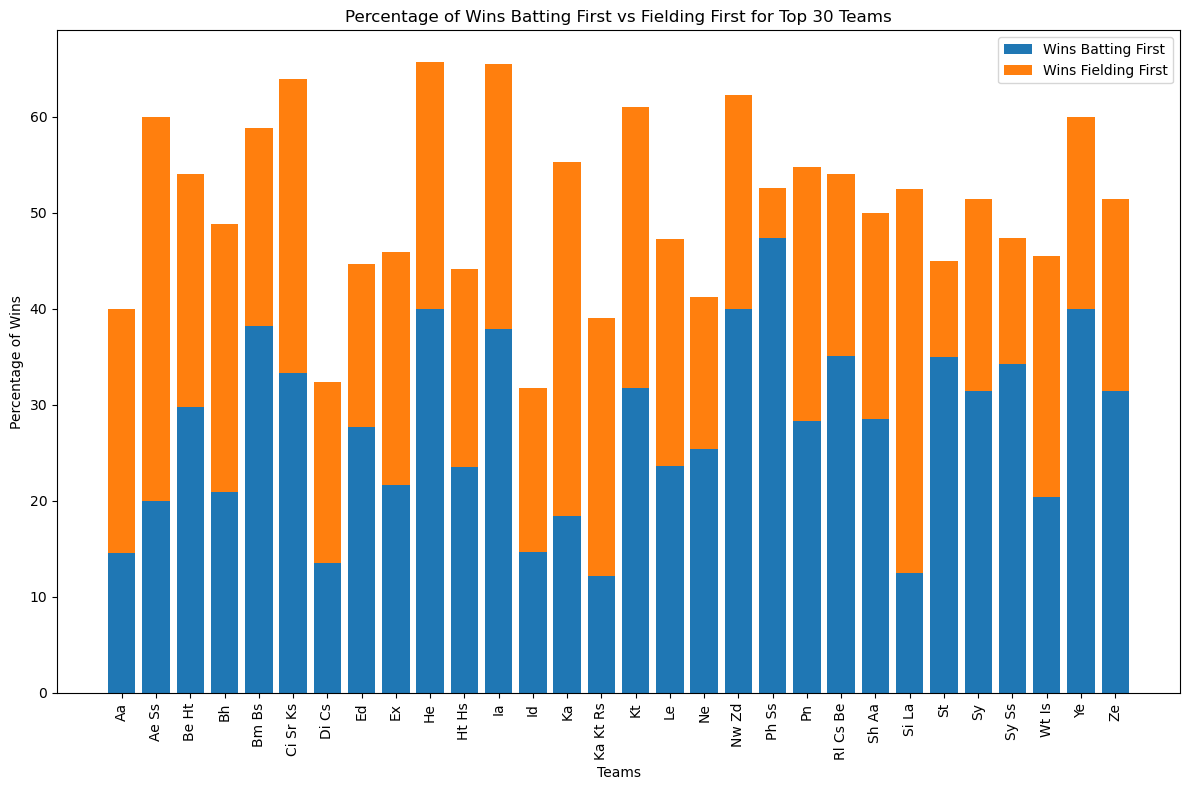

In [88]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'x' containing match information

# Step 1: Calculate the total number of matches played by each team
team1_matches = x['team1'].value_counts()
team2_matches = x['team2'].value_counts()
total_matches = team1_matches.add(team2_matches, fill_value=0)

# Step 2: Get the top 30 teams with the most number of matches
top_teams = total_matches.nlargest(30).index.tolist()

# Step 3: Filter matches data for the top 30 teams
top_teams_matches = x[(x['team1'].isin(top_teams)) | (x['team2'].isin(top_teams))]

# Step 4: Calculate percentage of wins while batting first and fielding first for each team
team_wins_batting_first = top_teams_matches[top_teams_matches['winner'] == top_teams_matches['bat_first']]['bat_first'].value_counts()
team_wins_fielding_first = top_teams_matches[top_teams_matches['winner'] != top_teams_matches['bat_first']]['bat_first'].value_counts()

# Ensure all top teams have data, even if they haven't won while batting first or fielding first
for team in top_teams:
    if team not in team_wins_batting_first.index:
        team_wins_batting_first[team] = 0
    if team not in team_wins_fielding_first.index:
        team_wins_fielding_first[team] = 0

team_wins_batting_first = team_wins_batting_first.sort_index()
team_wins_fielding_first = team_wins_fielding_first.sort_index()

team_wins_batting_first_percentage = (team_wins_batting_first / total_matches[top_teams]) * 100
team_wins_fielding_first_percentage = (team_wins_fielding_first / total_matches[top_teams]) * 100

# Step 5: Sort top teams in ascending order
top_teams_sorted = sorted(top_teams)

# Step 6: Plot the graph
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(top_teams_sorted, team_wins_batting_first_percentage.loc[top_teams_sorted], label='Wins Batting First')
ax.bar(top_teams_sorted, team_wins_fielding_first_percentage.loc[top_teams_sorted], bottom=team_wins_batting_first_percentage.loc[top_teams_sorted], label='Wins Fielding First')
ax.set_xlabel('Teams')
ax.set_ylabel('Percentage of Wins')
ax.set_title('Percentage of Wins Batting First vs Fielding First for Top 30 Teams')
ax.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


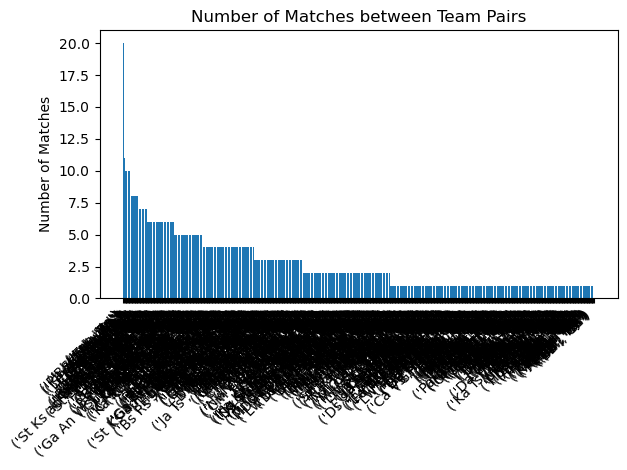

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'matches_data' containing match data

# Create a new column 'team_pair' to represent team pairs in each match
matchdata['team_pair'] = matchdata.apply(lambda row: tuple(sorted([row['team1'], row['team2']])), axis=1)

# Count the number of matches for each team pair
team_pair_counts = matchdata['team_pair'].value_counts()

# Plotting the graph
plt.bar(range(len(team_pair_counts)), team_pair_counts.values, align='center')
plt.xticks(range(len(team_pair_counts)), team_pair_counts.index, rotation=45, ha='right')
plt.ylabel('Number of Matches')
plt.title('Number of Matches between Team Pairs')
plt.tight_layout()
plt.show()
